**Trial 2 :** Variant 1: Multi-Scale + Dilation (Wide Receptive Field)
Uses different dilation rates in combination with kernel sizes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# load & Split data

In [ ]:
# Load feature and target data
features = pd.read_csv(r"D:\JN\data set\created dataset\ECG PCG feature(128+128=256).csv", header=None, skiprows=[0])
targets = pd.read_csv(r'D:\JN\data set\data from web\Reference_aug.csv', header=None)

print(features.shape)
print(targets.shape)

# Extract target column
y = targets.iloc[:, -1]  # Selecting the last column
X = features  # All feature columns

# Using .apply() method
y = y.apply(lambda x: max(x, 0))

# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Reshape data for Conv1D input
Xtrain_reshaped = Xtrain_scaled.reshape((Xtrain_scaled.shape[0], Xtrain_scaled.shape[1], 1))
Xtest_reshaped = Xtest_scaled.reshape((Xtest_scaled.shape[0], Xtest_scaled.shape[1], 1))

# Multi-Scale Convolutional Neural Network (MSCNN)¶

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Concatenate, Flatten, Dense

input_layer = Input(shape=(256, 1))

# Multi-scale convolutions with different dilation rates
conv3 = Conv1D(16, 3, dilation_rate=1, padding='same', activation='relu')(input_layer)
conv5 = Conv1D(16, 5, dilation_rate=2, padding='same', activation='relu')(input_layer)
conv7 = Conv1D(16, 7, dilation_rate=3, padding='same', activation='relu')(input_layer)

merged = Concatenate()([conv3, conv5, conv7])
merged = BatchNormalization()(merged)
merged = Dropout(0.4)(merged)

# Continue with normal convolution layers
conv = Conv1D(32, 3, activation='relu', padding='same')(merged)
conv = BatchNormalization()(conv)
conv = Dropout(0.4)(conv)
conv = Conv1D(16, 3, activation='relu', padding='same')(conv)

# Dense layers
flattened = Flatten()(conv)
dense = Dense(128, activation='relu')(flattened)
dense = Dense(64, activation='relu')(dense)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
# Train model
history = model.fit(Xtrain_reshaped, Ytrain, epochs=60, batch_size=32, validation_split=0.2)

Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.5245 - loss: 0.8247 - val_accuracy: 0.5665 - val_loss: 0.6796
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6419 - loss: 0.6320 - val_accuracy: 0.5348 - val_loss: 0.6743
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6582 - loss: 0.6023 - val_accuracy: 0.6108 - val_loss: 0.6599
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7210 - loss: 0.5525 - val_accuracy: 0.6392 - val_loss: 0.6385
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.7055 - loss: 0.5483 - val_accuracy: 0.6614 - val_loss: 0.6175
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7423 - loss: 0.5075 - val_accuracy: 0.5918 - val_loss: 0.7100
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7397 - loss: 0.5328 - val_accuracy: 0.6772 - val_loss: 0.5797
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7731 - loss: 0.4562 - val_accuracy: 0.6899 - v

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7427 - loss: 1.3477
Test Accuracy: 72.91%
Test Loss: 1.3771
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       190
           1       0.76      0.70      0.73       205

    accuracy                           0.73       395
   macro avg       0.73      0.73      0.73       395
weighted avg       0.73      0.73      0.73       395



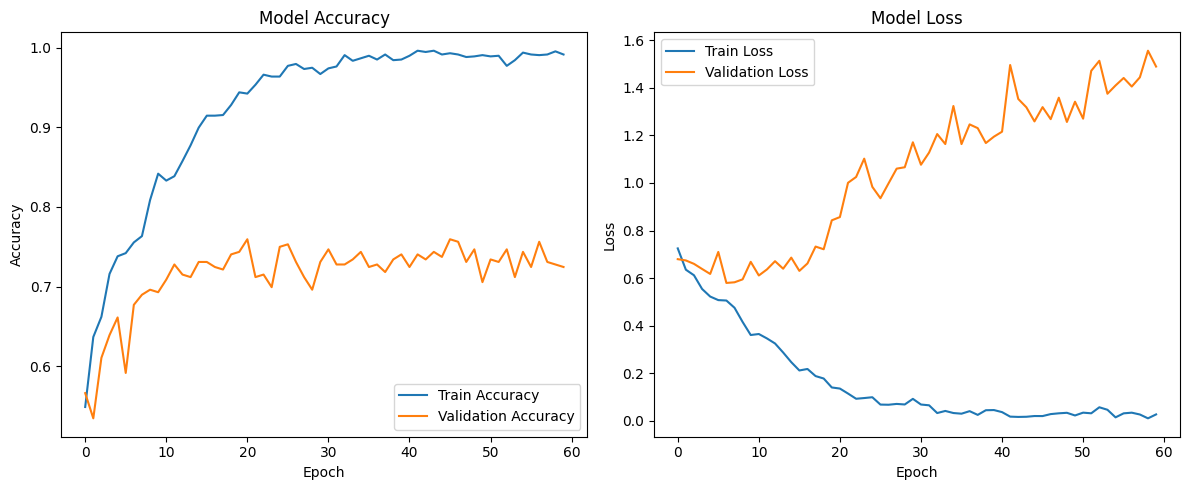


ROC AUC: 0.8143


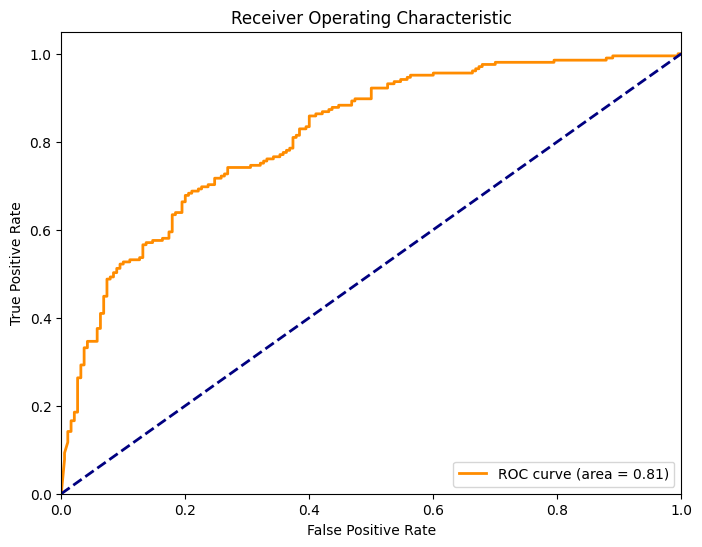

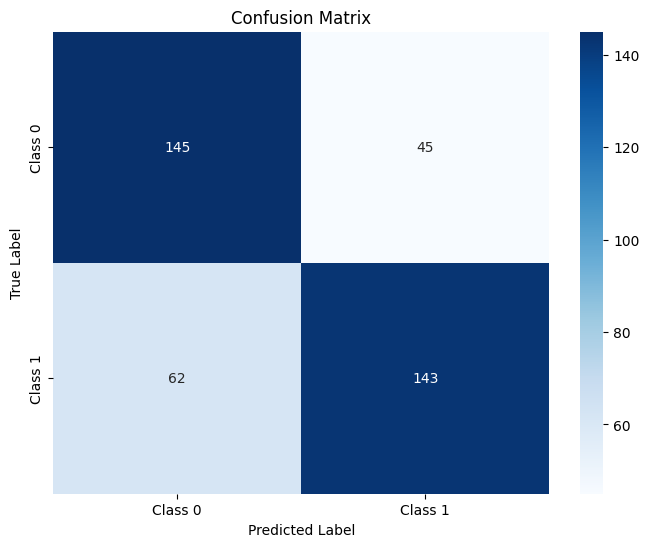

In [5]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(Xtest_reshaped, Ytest)
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Loss: {loss:.4f}")
#--------------------------------------------------------------------------
Ypred = model.predict(Xtest_reshaped)
Ypred_classes = (Ypred > 0.5).astype(int)
Ypred_classes_flat = Ypred_classes.flatten()

# Print classification report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(Ytest, Ypred_classes_flat)) # Use Ytest directly
#-------------------------------------------------------------------------
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
#------------------------------------------------------------------------
roc_auc = roc_auc_score(Ytest, Ypred[:, 0])
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot ROC curve
# Use Ytest for true labels and Ypred[:, 0] for predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(Ytest, Ypred[:, 0])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
#------------------------------------------------------------------------
cm = confusion_matrix(Ytest, Ypred_classes_flat)
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1'] # Or provide your actual class names if available

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()